In [1]:
import cirq
import qiskit
import random
import numpy as np

from cirq.contrib.svg import SVGCircuit

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\qiskit\__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


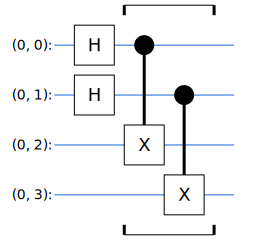

In [2]:
A1, A2, B, C = cirq.GridQubit.rect(1,4)

circuit = cirq.Circuit(
    cirq.H(A1), cirq.CNOT(control=A1, target=B),
    cirq.H(A2), cirq.CNOT(control=A2, target=C)
)


SVGCircuit(circuit)

In [3]:
def getCircuit(classical_bits):
    """
        getCircuit(circuit, ["01", "10"])
            => X(A1), Z(A2)
    """
    global circuit
    circuit_copy = circuit.copy()
    
    def operate(circuit, target, bits):
        if bits[0] == '1':
            circuit.append(cirq.Z(target))
        if bits[1] == '1':
            circuit.append(cirq.X(target))
        
        return circuit
    
    operate(circuit_copy, A1, classical_bits[0])
    operate(circuit_copy, A2, classical_bits[1])

    return circuit_copy

In [4]:
def buildU(p):
    matrixes = [
        cirq.unitary(cirq.I),cirq.unitary(cirq.X),
        cirq.unitary(cirq.Y),cirq.unitary(cirq.Z)
    ]
    
    U = np.zeros((4,4)).astype('complex128')
    pos = 0
    for i in range(4):
        for j in range(4):
            U += p[pos] * np.kron(matrixes[i], matrixes[j]).astype('complex128')
            pos += 1
            
    from qiskit.extensions import HamiltonianGate
    op = HamiltonianGate(U, 0.1)
    
    return op.to_matrix()

In [5]:
def generateRous(U, targets):
    bits = ["00", "01", "10", "11"]
    indexes = [0, 2] if targets == "AB" else [1, 3]
    rous = []
    
    from qiskit.quantum_info import partial_trace
    
    for i in range(4):
        for j in range(4):
            circuit = getCircuit([bits[i], bits[j]])
            circuit.append(cirq.ops.MatrixGate(U)(A1, A2))
            
            rous.append( partial_trace(cirq.unitary(circuit), indexes) )
    
    return rous

In [6]:
def sub_L(rou, sigma, loss_function):
    if loss_function == "F":
        # fidelity
        from cirq.qis import fidelity
        
        return fidelity(rou.data, sigma.data)
    
    elif loss_function == "D":
        # trace
        A = (rou - sigma)
        A = A.data
        tr = 0.5 * np.trace( (A.conj().T @ A) * 0.5 )
        
        return tr
    else:
        return 0

In [7]:
def L(p, loss_function):
    n = 2
    U = buildU(p)
    rous = []
    for i in range(n):
        rous.append(generateRous(n, U, [i, i + n]))
    
    loss = 0.0
    size = 2 ** (2 * n)
    book = set()
    for i in range(size):
        for j in range(size):
            if i != j and f"{i},{j}" not in book:
                for k in range(n):
                    l = sub_L(rous[k][i], rous[k][j], loss_function)
                    print(l)
                    loss += l

                book.add(f"{i},{j}")
                book.add(f"{j},{i}")
                
    print(rous[0][0])
    print(rous[0][2])
    
    loss = 1 / (n * ((size ** 2 - size)/2)) * loss
    if loss_function == "F":
        loss *= -1
    
    return loss


In [14]:
def GradientCalculator(bits, p, epsilon, loss_function):
    derivates = np.zeros(len(p))
    
    for i, param in enumerate(p):
        p[i] += epsilon
        l_pe = L(bits, p, loss_function)
        p[i] -= epsilon
        l_p = L(bits, p, loss_function)
        
        derivates[i] = (l_pe - l_p) / epsilon
        
#     print(derivates)
    return derivates, l_p

In [15]:
params = []

def SDCLearner(n, *, loss_function="D", epoch=1000, epsilon=0.01):
    # 1. initialize the parameters with uniformly random nunbers
    size = 2 ** (2 * n)
    bits = ["01", "10"]
    p = np.random.uniform(-1, 1, size)
    
    # Adam parameters:
    momentum, s = 0, 0
    alpha = 0.001
    belta1 = 0.9; belta2 = 0.999
    e = 1e-8
    
    global params
    
    t = 0
    while t < epoch:
        # repeat
        t += 1
        grad, loss = GradientCalculator(bits, p, epsilon, loss_function)
        
        # Adam Optimizer
        momentum = belta1 * momentum + (1 - belta1) * grad
        s = belta2 * s + (1 - belta2) * (grad ** 2)
        m_ = momentum / (1 - belta1 ** t)
        s_ = s / (1 - belta2 ** t)

        # update parameters
        p = p - alpha * (m_ / ( s_ ** 0.5 + e ))
        
        # log
        print('epoch: [{}/{}] - loss: {} end.'.format(t, epoch, loss))
    
    params = p

In [16]:
SDCLearner(2, epoch=1)

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


epoch: [1/1] - loss: (6.046369601389095+0j) end.


In [14]:
params

array([ 0.01582897, -0.27174117,  0.40245615, -1.15137521,  1.47279292,
       -1.20539867,  0.11732657, -0.97726707, -1.1839263 ,  0.68715609,
        0.17663543,  1.5201344 , -1.32550229,  0.82466927,  1.61649694,
        1.54534631])

In [15]:
buildU(params)

array([[ 0.96031136+0.08677763j, -0.15727003-0.0914257j ,
        -0.02057921-0.0725707j , -0.08623596+0.15508892j],
       [ 0.22856262-0.01624983j,  0.89299848+0.16494118j,
        -0.07631194+0.11240413j,  0.21441912-0.24168044j],
       [ 0.04311023-0.02310721j,  0.03041292+0.07975324j,
         0.96938475+0.13471977j,  0.15043891+0.09916636j],
       [ 0.0628764 +0.10686878j, -0.29520645-0.21868524j,
        -0.0787735 +0.10858323j,  0.83139596-0.37475422j]])

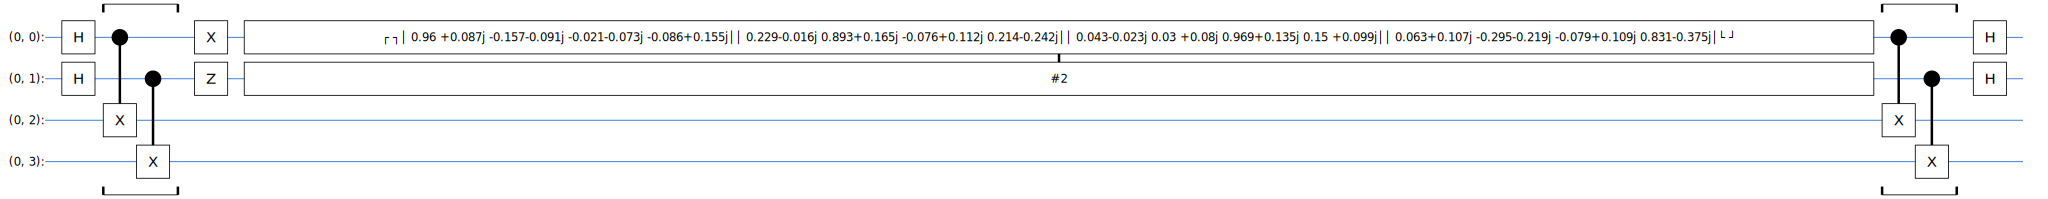

In [16]:
circuit_test = getCircuit(["01", "10"])
circuit_test.append(cirq.ops.MatrixGate(buildU(params))(A1, A2))

circuit_test.append([cirq.CNOT(control=A1, target=B), cirq.H(A1)])
circuit_test.append([cirq.CNOT(control=A2, target=C), cirq.H(A2)])

SVGCircuit(circuit_test)

In [17]:
circuit_test.append(cirq.measure(A1, B, key='A1B'))

sim = cirq.Simulator()
output = sim.run(circuit_test, repetitions=1000)
print(output.histogram(key="A1B"))

Counter({1: 862, 3: 73, 2: 33, 0: 32})


In [18]:
circuit_test.append(cirq.measure(A2, C, key='A2C'))

output = sim.run(circuit_test, repetitions=1000)
print(output.histogram(key="A2C"))

Counter({2: 876, 0: 70, 3: 29, 1: 25})


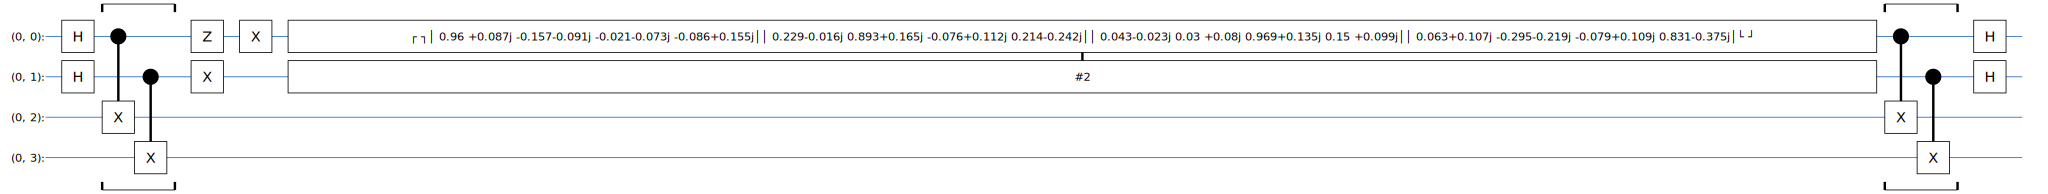

In [19]:
circuit_test2 = getCircuit(["11", "01"])
circuit_test2.append(cirq.ops.MatrixGate(buildU(params))(A1, A2))

circuit_test2.append([cirq.CNOT(control=A1, target=B), cirq.H(A1)])
circuit_test2.append([cirq.CNOT(control=A2, target=C), cirq.H(A2)])

SVGCircuit(circuit_test2)

In [20]:
circuit_test2.append(cirq.measure(A1, B, key='A1B'))

sim = cirq.Simulator()
output = sim.run(circuit_test2, repetitions=3000)
print(output.histogram(key="A1B"))

Counter({3: 2511, 1: 219, 2: 140, 0: 130})


In [21]:
circuit_test2.append(cirq.measure(A2, C, key='A2C'))

output = sim.run(circuit_test2, repetitions=3000)
print(output.histogram(key="A2C"))

Counter({1: 2637, 3: 217, 0: 76, 2: 70})
